# Optimizing Cost and Profitability

## Context : 
A food delivery service is facing challenges in achieving profitability across its operations. With a dataset of 1,000 food orders, the service seeks to understand the dynamics of its cost structure and profitability to identify strategic opportunities for improvement.

The dataset contains comprehensive details on food orders, including Order ID, Customer ID, Restaurant ID, Order and Delivery Date and Time, Order Value, Delivery Fee, Payment Method, Discounts and Offers, Commission Fee, Payment Processing Fee, and Refunds/Chargebacks. This data provides a foundation for analyzing the cost structure and profitability of the food delivery service.

## Aim:
1. Detailed Cost Analysis: Identifying the major cost components associated with delivering food orders, including direct costs like delivery fees and indirect costs like discounts and payment processing fees.
2. Profitability Evaluation: Calculating the profitability of individual orders and aggregating this data to assess overall profitability. This involves examining how revenue generated from commission fees measures against the total costs.
3. Strategic Recommendations for Improvement: Based on the cost and profitability analysis, identifying actionable strategies to reduce costs, adjust pricing, commission fees, and discount strategies to improve profitability. This includes finding a “sweet spot” for commission and discount percentages that ensures profitability across orders.
4. Impact Simulation of Proposed Strategies: Simulating the financial impact of the recommended strategies on profitability, using the dataset to forecast how adjustments in commission rates and discount strategies could potentially transform current losses into profits.tability, using the dataset to forecast how adjustments in commission rates and discount strategies could potentially transform current losses into profits.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [51]:
df = pd.read_csv('/kaggle/input/food-orders-delivery-data/food_orders_new_delhi.csv')

In [52]:
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [53]:
df.shape

(1000, 12)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [55]:
#checking missing values
df.isnull().sum()

Order ID                    0
Customer ID                 0
Restaurant ID               0
Order Date and Time         0
Delivery Date and Time      0
Order Value                 0
Delivery Fee                0
Payment Method              0
Discounts and Offers      185
Commission Fee              0
Payment Processing Fee      0
Refunds/Chargebacks         0
dtype: int64

In [56]:
# Percentage of missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("Percentage of Missing Values \n", missing_percentage)

Percentage of Missing Values 
 Order ID                   0.0
Customer ID                0.0
Restaurant ID              0.0
Order Date and Time        0.0
Delivery Date and Time     0.0
Order Value                0.0
Delivery Fee               0.0
Payment Method             0.0
Discounts and Offers      18.5
Commission Fee             0.0
Payment Processing Fee     0.0
Refunds/Chargebacks        0.0
dtype: float64


In [57]:
df.duplicated().sum()

0

In [58]:
# dropping those missing records
df.dropna(inplace = True)

In [59]:
df.columns

Index(['Order ID', 'Customer ID', 'Restaurant ID', 'Order Date and Time',
       'Delivery Date and Time', 'Order Value', 'Delivery Fee',
       'Payment Method', 'Discounts and Offers', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks'],
      dtype='object')

Data Preprocessing

In [60]:
# Convert 'Order Date and Time' and 'Delivery Date and Time' to datetime format
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'], errors='coerce')
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'], errors='coerce')

# Calculate Delivery Duration in minutes (optional)
df['Delivery Duration in Min'] = (df['Delivery Date and Time'] - df['Order Date and Time']).dt.total_seconds() / 60

# Display updated dataframe
df.head()


,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks,Delivery Duration in Min
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,88.0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,35.0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,58.0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,89.0
5,6,C7265,R2777,2024-01-25 04:36:52,2024-01-25 05:27:52,439,20,Cash on Delivery,10%,92,27,150,51.0


## Calculating Total Cost and Total Profit

In [62]:
# Create Total Cost Column
df['Total Cost'] = df['Delivery Fee'] +  df['Payment Processing Fee'] + df['Refunds/Chargebacks']

# Create Profit Column
df['Profit'] = df['Commission Fee'] - df['Total Cost']

# Display basic statistics to understand the data
df.head()


,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks,Delivery Duration in Min,Total Cost,Profit
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,88.0,47,103
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,35.0,63,135
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,58.0,75,120
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,89.0,80,50
5,6,C7265,R2777,2024-01-25 04:36:52,2024-01-25 05:27:52,439,20,Cash on Delivery,10%,92,27,150,51.0,197,-105


## Average Cost Components

In [64]:
# Calculate the average, minimum, and maximum values for each cost component
cost_summary = df[['Delivery Fee','Payment Processing Fee', 'Refunds/Chargebacks', 'Total Cost']].agg(['mean', 'min', 'max'])

print("Cost Component Summary:")
print(cost_summary)


Cost Component Summary:
      Delivery Fee  Payment Processing Fee  Refunds/Chargebacks  Total Cost
mean     28.355828               29.906748            27.055215   85.317791
min       0.000000               10.000000             0.000000   10.000000
max      50.000000               50.000000           150.000000  250.000000


## Cost Distribution

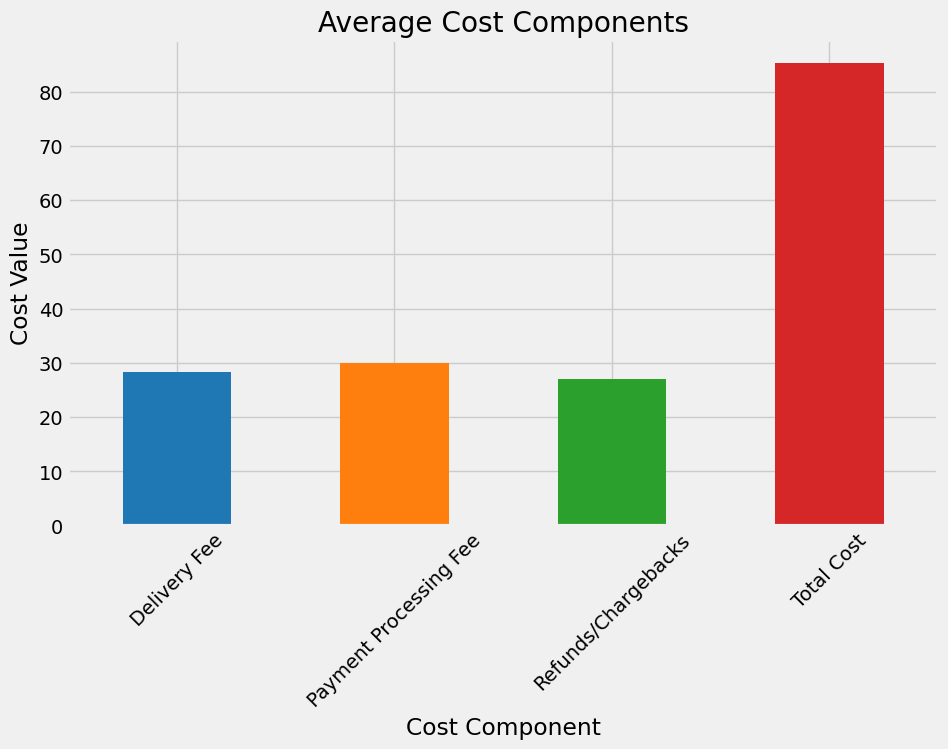

In [65]:
# Plot the average cost components
cost_summary.loc['mean'].plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Average Cost Components')
plt.ylabel('Cost Value')
plt.xlabel('Cost Component')
plt.xticks(rotation=45)
plt.show()


## Major Cost Drivers

Average Percentage Contribution to Total Cost:
Delivery Fee %      36.770912
Processing Fee %    46.304998
Refunds %           16.924090
dtype: float64


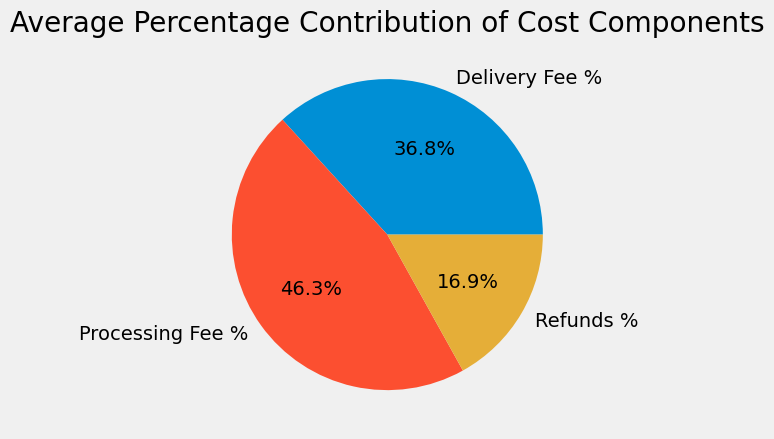

In [70]:
# Calculate the proportion of each cost component relative to Total Cost
df['Delivery Fee %'] = (df['Delivery Fee'] / df['Total Cost']) * 100
df['Processing Fee %'] = (df['Payment Processing Fee'] / df['Total Cost']) * 100
df['Refunds %'] = (df['Refunds/Chargebacks'] / df['Total Cost']) * 100

# Calculate average percentage contribution
average_percentage_contribution = df[['Delivery Fee %', 'Processing Fee %', 'Refunds %']].mean()

print("Average Percentage Contribution to Total Cost:")
print(average_percentage_contribution)

# Plot the percentage contribution
average_percentage_contribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Average Percentage Contribution of Cost Components')
plt.ylabel('')
plt.show()


In [87]:
df_num = df.select_dtypes(exclude = 'object')
df_num.columns

Index(['Order ID', 'Order Date and Time', 'Delivery Date and Time',
       'Order Value', 'Delivery Fee', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks',
       'Delivery Duration in Min', 'Total Cost', 'Profit', 'Delivery Fee %',
       'Processing Fee %', 'Refunds %', 'Profit Margin (%)'],
      dtype='object')

In [90]:
columns_to_plot = [
    'Profit',                    # Overall profitability distribution
    'Profit Margin (%)',         # Variation and distribution of profit margins
    'Delivery Duration in Min',  # Delivery time and its impact on efficiency
    'Total Cost',                # Total cost per order to analyze outliers
    'Order Value'                # Distribution of order values
]

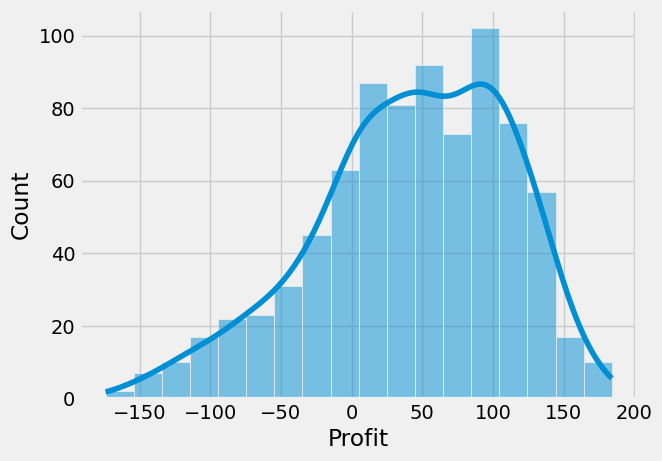

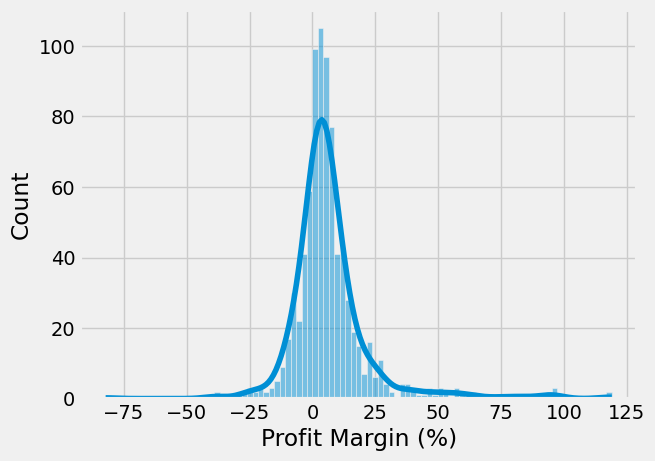

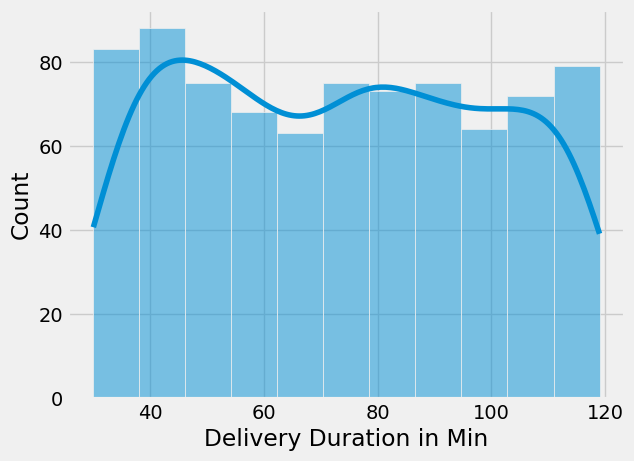

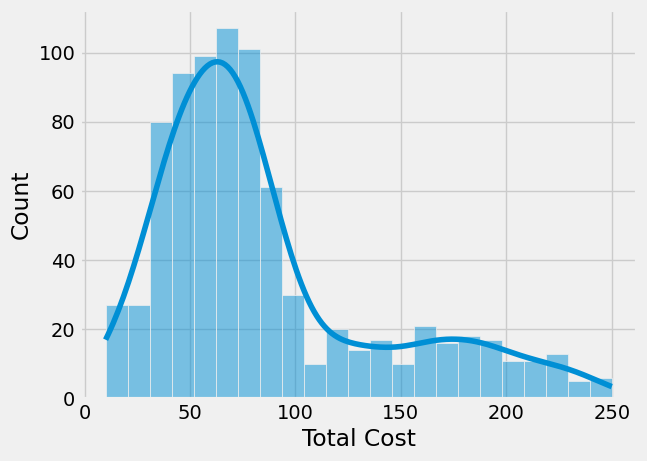

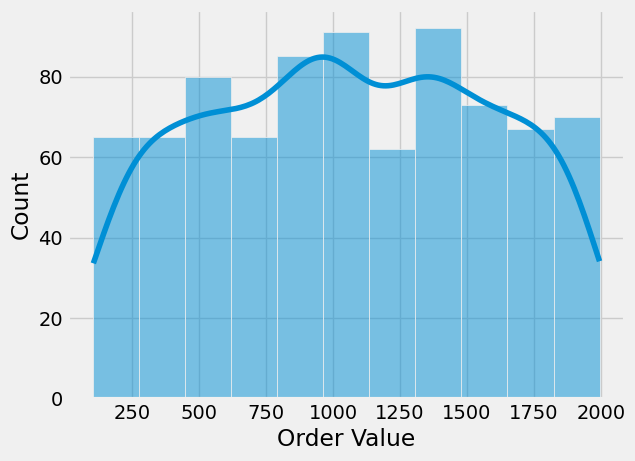

In [91]:
for col in columns_to_plot:
    sns.histplot(x = col, data =df, kde = True)
    plt.show()

## Observations

1. Profit is slightly left skewed, showing there are few orders which were loss making
2. Profit margin is Almost Normally distributed
3. The Total cost is Right skewed showing there are few order with very high total cost
4. For order value we can see multiple peaks and somewhat uniformy distributed

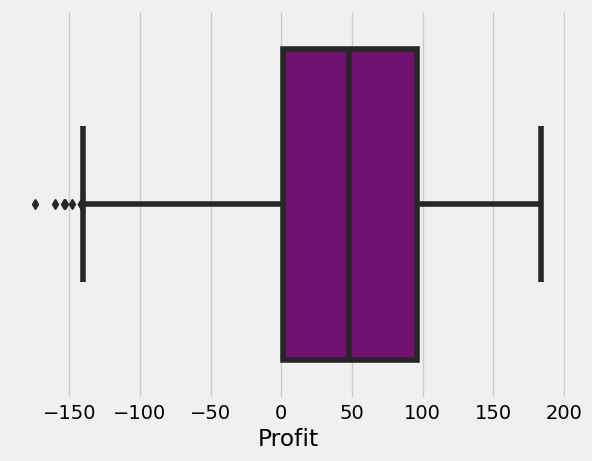

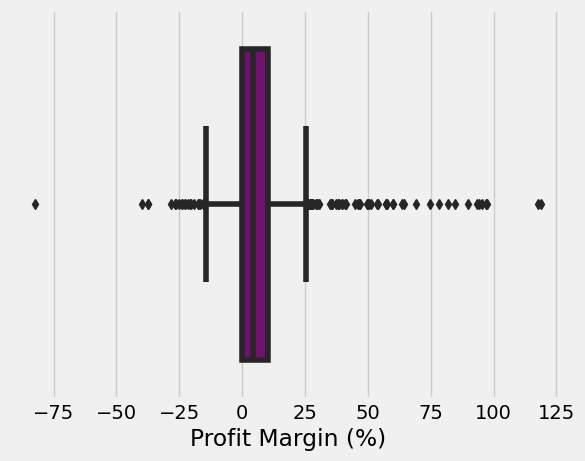

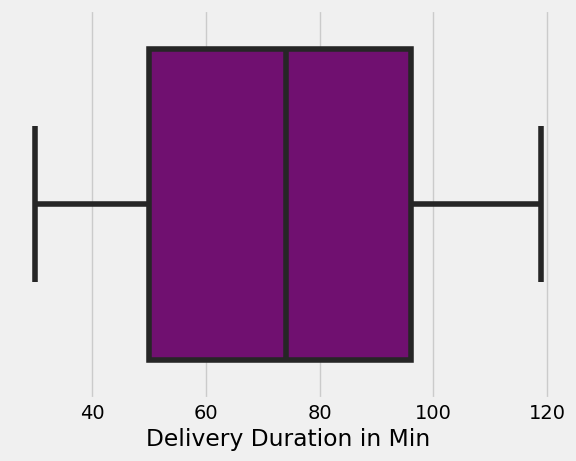

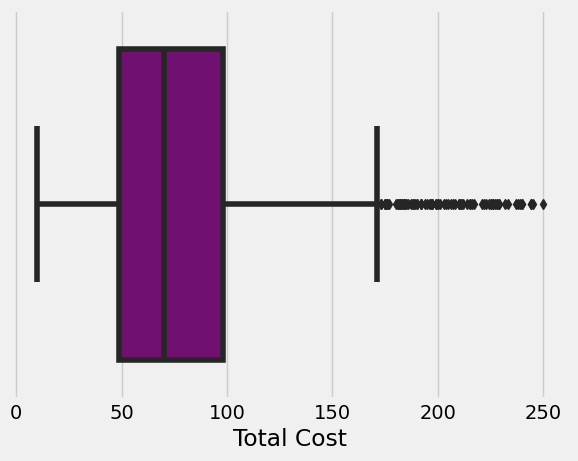

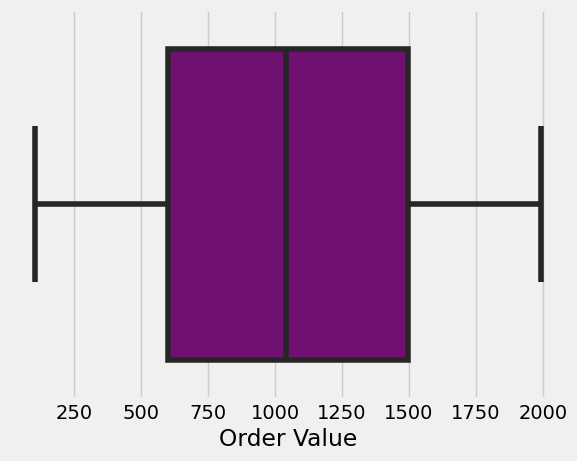

In [94]:
for col in columns_to_plot:
    sns.boxplot(x = col, data =df, color = 'purple')
    plt.show()

## Observations

1. Delivery duration is between 50 to 90 min
2. There are multiple outliers for profit margin
3. The order value spreads bewyeen 600 to 1500
4. Total cost is between 50 to 100

## Correlation Analysis

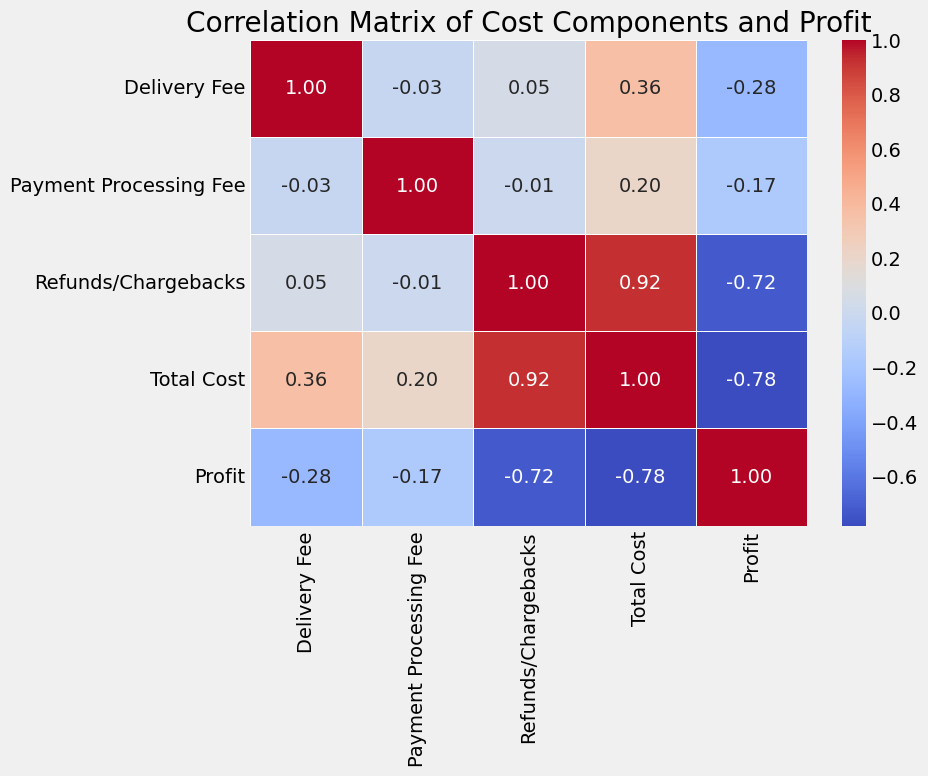

In [72]:
# Correlation matrix
correlation_matrix = df[['Delivery Fee','Payment Processing Fee', 'Refunds/Chargebacks', 'Total Cost', 'Profit']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Cost Components and Profit')
plt.show()


## Observationas and Insights

**There are 3 major Cost drivers**

1. Delivery Fee
2. Payment Processing fee
3. Refunds

Among these, the Payment proc fee constitutes 46.3% of the Total cost

 from the Correlation heatmap we can observe that , with Increasing Delivery fee , it increases the Total cost significanly(Strong Pos Correlation)  

   

## Calculate Profitability for Each Order

Profit Margin

In [73]:
# Calculate profit margin for each order
df['Profit Margin (%)'] = (df['Profit'] / df['Order Value']) * 100

# Display basic statistics for profit margin
print("Profit Margin Summary:")
print(df['Profit Margin (%)'].describe())

# Display the first few rows to verify
df[['Order ID', 'Order Value', 'Total Cost', 'Profit', 'Profit Margin (%)']].head()


Profit Margin Summary:
count    815.000000
mean       7.007293
std       16.708693
min      -82.236842
25%        0.105653
50%        4.340568
75%       10.319279
max      119.047619
Name: Profit Margin (%), dtype: float64


,Order ID,Order Value,Total Cost,Profit,Profit Margin (%)
0,1,1914,47,103,5.381400
1,2,986,63,135,13.691684
2,3,937,75,120,12.806830
4,5,1992,80,50,2.510040
5,6,439,197,-105,-23.917995


Aggregate Profitibility

In [74]:
# Total Profit/Loss
total_profit = df['Profit'].sum()
print(f"Total Profit/Loss: ${total_profit:.2f}")

# Percentage of profitable and unprofitable orders
profitable_orders = (df['Profit'] > 0).sum()
unprofitable_orders = (df['Profit'] <= 0).sum()
total_orders = len(df)

print(f"Profitable Orders: {profitable_orders} ({(profitable_orders / total_orders) * 100:.2f}%)")
print(f"Unprofitable Orders: {unprofitable_orders} ({(unprofitable_orders / total_orders) * 100:.2f}%)")


Total Profit/Loss: $34264.00
Profitable Orders: 612 (75.09%)
Unprofitable Orders: 203 (24.91%)


## Distribution of Profit margin

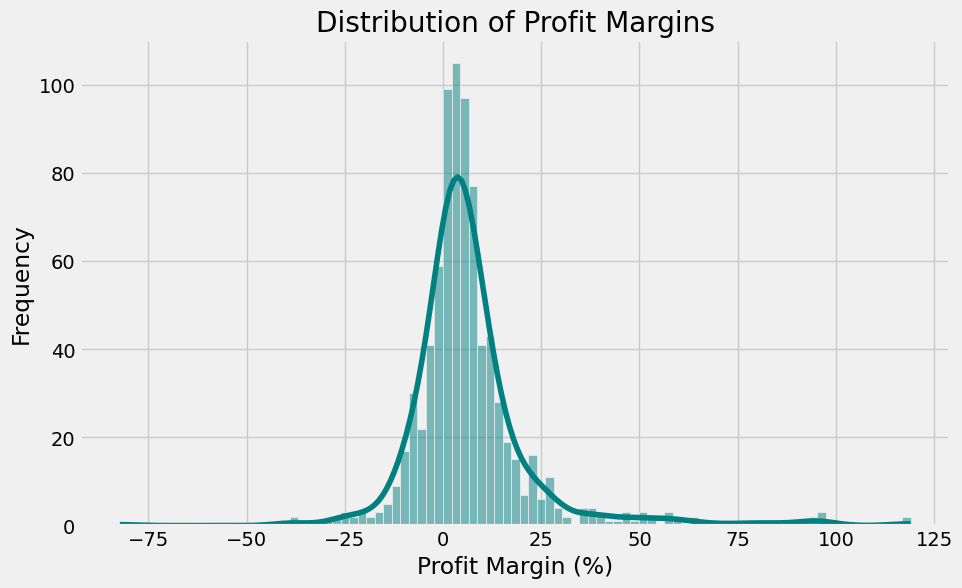

In [75]:
# Plot profit margin distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Profit Margin (%)'], kde=True, color='teal')
plt.title('Distribution of Profit Margins')
plt.xlabel('Profit Margin (%)')
plt.ylabel('Frequency')
plt.show()


## Profitibility Analysis by Segment

1. By restaurent
2. By Payment method

In [76]:
# Group by Restaurant ID and calculate total profit and average profit margin
restaurant_profitability = df.groupby('Restaurant ID').agg(
    Total_Profit=('Profit', 'sum'),
    Average_Profit_Margin=('Profit Margin (%)', 'mean'),
    Order_Count=('Order ID', 'count')
).sort_values(by='Total_Profit', ascending=False)

print("Top 5 Most Profitable Restaurants:")
print(restaurant_profitability.head())

Top 5 Most Profitable Restaurants:
               Total_Profit  Average_Profit_Margin  Order_Count
Restaurant ID                                                  
R2222                   392               8.502110            3
R2799                   300               8.588936            3
R2569                   290              13.764409            2
R2215                   285              11.663544            3
R2016                   278              12.684072            4


In [77]:
# Group by Payment Method and calculate total profit and average profit margin
payment_method_profitability = df.groupby('Payment Method').agg(
    Total_Profit=('Profit', 'sum'),
    Average_Profit_Margin=('Profit Margin (%)', 'mean'),
    Order_Count=('Order ID', 'count')
).sort_values(by='Total_Profit', ascending=False)

print("Profitability by Payment Method:")
print(payment_method_profitability)


Profitability by Payment Method:
                  Total_Profit  Average_Profit_Margin  Order_Count
Payment Method                                                    
Digital Wallet           12006               7.054392          249
Credit Card              11682               6.905982          274
Cash on Delivery         10576               7.062195          292


## Observation and Insights

- Total Profit/Loss: $34264.00
- Profitable Orders: 612 (75.09%)
- Unprofitable Orders: 203 (24.91%)
- The avg profit margin is 7%
- Top restaurent with highest profits -> R2222 R2799 R2569 R2215 R2016
- Top Payment method gaining highest Profit = Digital Wallet

### **Strategic Recommendations**  

**1. Reduce Payment Processing Fees (46.3% of Total Cost)**  
- Negotiate lower fees with payment processors.  
- Promote low-cost digital wallet usage through discounts or cashback.  
- Implement surcharges on high-cost payment methods like credit cards.  

**2. Minimize Refunds and Chargebacks (31.7% of Total Cost)**  
- Offer partial refunds or store credits for low-margin orders.  
- Strengthen quality assurance with restaurants.  
- Implement fraud detection for high-risk refunds.  

**3. Optimize Delivery Fee Structure**  
- Use dynamic pricing: reduce fees for high-value orders, increase for low-value ones.  
- Offer free delivery for orders above a set threshold.  

**4. Leverage Top Restaurants**  
- Boost partnerships with top-performing restaurants (e.g., R2222, R2799).  
- Increase their visibility on the platform and introduce exclusive offers.  
- Negotiate higher commissions from these restaurants.  

**5. Focus on Digital Wallets (Highest Profit Margin)**  
- Promote digital wallet payments with exclusive offers.  
- Partner with wallet providers for joint cashback promotions.  

**6. Refine Discount Strategies**  
- Limit discounts on low-margin or unprofitable orders.  
- Offer targeted discounts to profitable, hi# gh-frequency customers.  

**Expected Impact**  
- Lower costs and increased profitability.  
- Improved customer retention through better pricing and service quality.